In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch  as th
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import pandas as pd
import seaborn as sns
import random
from tqdm import tqdm
from transformers import Wav2Vec2Processor, Wav2Vec2ForCTC
from torch.utils.data import TensorDataset, DataLoader
from conformer import Conformer

ModuleNotFoundError: No module named 'conformer'

In [3]:
###### Set the device to use Apple M1 GPU #######
device = th.device('mps')

In [17]:
class RandomProjectionQuantizer(nn.Module):
    def __init__(self, input_dim, quantizer_dim, codebook_size, random_state=None, device='cpu'):
        super().__init__()
        self.random_projection = nn.Linear(input_dim, quantizer_dim, bias=False)
        nn.init.xavier_uniform_(self.random_projection.weight)

        self.code_book = nn.Parameter(th.randn(quantizer_dim, codebook_size)).to(device).detach().requires_grad_(False)

        self.random_projection.weight.requires_grad = False
        #self.code_book.requires_grad = False

        self.device = device
        if random_state is not None:
            th.manual_seed(random_state)

    @th.no_grad()
    def forward(self, input_values: th.Tensor, mask_time_indices: th.Tensor) -> th.Tensor:
        """
        Args:
            input_values (torch.Tensor): with shape `(B, L, D)`
            mask_time_indices (torch.Tensor): with shape `(B, L)`

        Returns:
            torch.Tensor with shape `(N)`

        """
        shape = input_values.shape
        targets = self.random_projection(input_values)

        repeated_code_book = self.code_book.unsqueeze(0).unsqueeze(0).expand(shape[0], shape[1], -1, -1)

        # Effectuer l'opération de soustraction
        vector_distances = th.norm(targets.unsqueeze(-1).expand_as(repeated_code_book) - repeated_code_book, dim=2)


        labels = th.argmin(vector_distances, dim=-1)

        return labels

class ConformerModel_nul(nn.Module):
    def __init__(self, input_size=600, hidden_size=64, output_size=192):
        super(ConformerModel, self).__init__()

        # Couches Conformer
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.attention = ConformerAttention(hidden_size)
        self.linear3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.attention(x)
        x = self.linear3(x)
        return x

class ConformerModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ConformerModel, self).__init__()
        self.conformer = Conformer(
            num_features=input_size,
            num_classes=num_classes,
            encoder_dim=256,  # Dimension de l'encodeur
            num_layers=5,     # Nombre de couches
            num_attention_heads=4,  # Nombre de têtes d'attention
            feed_forward_expansion_factor=2,  # Facteur d'expansion de la couche feed-forward
            dropout=0.1,      # Taux de dropout
            activation="gelu",  # Fonction d'activation (gelu, relu, swish, etc.)
        )

    def forward(self, x):
        # x est un tensor d'entrée de forme (batch_size, seq_length, input_size)
        # Le modèle Conformer prend en entrée un tensor de forme (batch_size, seq_length, num_features)
        # où num_features est la dimension des caractéristiques du signal biologique
        output = self.conformer(x)
        return output


class BestRqFramework(nn.Module):
    def __init__(self, encoder: nn.Module, num_temporal_dimension_reduction_steps: int, input_feature_size: int, encoder_hidden_size: int, num_code_books: int,
                 mask_time: int, stride_time: int, random_state : int, mask_prob: float = 0.1, batch_size : int = 200, num_masks_per_signal :int = 5):
        super().__init__()
        self.K = num_temporal_dimension_reduction_steps
        self.random_state = random_state
        self.batch_size = batch_size
        self.layer_norm = nn.LayerNorm(input_feature_size)
        self.random_projection_quantizer = RandomProjectionQuantizer(input_feature_size, encoder_hidden_size, num_code_books, random_state = random_state)
        self.encoder = encoder
        self.out_linear = nn.Linear(192, 1)
        self.num_time_steps = int(mask_time // (stride_time * self.K))
        self.mask_prob = mask_prob
        self.mask_time = mask_time
        self.num_masks_per_signal = num_masks_per_signal

    def split_batch(self, X, y):
        dataset = TensorDataset(X, y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        return data_loader


    def forward(self, input_values: th.Tensor):
        """
        Args:
            input_values (th.Tensor): with shape `(B, T, D)`

        Returns:

        """

        input_values = self.layer_norm(input_values)

        masked_input_values, time_mask_indices = self.masking(input_values.clone())

        labels = self.random_projection_quantizer(input_values, time_mask_indices)

        print(masked_input_values.shape)

        encoder_out = self.encoder(masked_input_values.view(-1))

        targets = encoder_out[time_mask_indices]

        targets_out = self.out_linear(targets)

        return targets_out, labels[time_mask_indices == 1]



    def masking(self, input_tensor, min_mask=0):
        """
        Generate a mask to randomly mask a subset of values based on the input tensor and probability.

        Args:
        - input_tensor (torch.Tensor): Input tensor for which the mask needs to be generated.
        - prob (float): Probability of masking each valid position.
        - min_mask (float): Minimum number of positions to mask.

        Returns:
        - subset_mask (torch.Tensor): Binary mask indicating positions to be masked (True) and positions to be kept (False).
        """
        batch, seq, device = *input_tensor.shape[:-1], input_tensor.device
        seq_mask = th.ones((batch, seq), dtype=th.bool, device=device)  # Assume all positions are valid

        num_to_mask = (seq_mask.sum(dim=-1, keepdim=True) * self.mask_prob).clamp(min=min_mask)
        logits = th.rand((batch, seq), device=device)
        logits = logits.masked_fill(~seq_mask, -1)

        randperm = logits.argsort(dim=-1).float()

        num_padding = (~seq_mask).sum(dim=-1, keepdim=True)
        randperm -= num_padding

        subset_mask = randperm < num_to_mask
        subset_mask.masked_fill_(~seq_mask, False)
        masked_tensor = input_tensor.clone()
        values_to_change = masked_tensor[subset_mask].clone()
        shape = values_to_change.shape
        for _ in range(self.num_masks_per_signal):
            idx = random.randint(0, int(shape[1]))
            if idx + self.mask_time <= shape[1]:
                values_to_change[:, idx:idx+self.mask_time] = th.normal(mean = 0, std = 0.1, device = device, size= (shape[0], self.mask_time))
        masked_tensor[subset_mask] = values_to_change
        return masked_tensor, subset_mask

In [18]:
def pretrain(trainloader, validloader, model, epochs=10, lr=1e-3):

    optimizer = optim.Adam(model.encoder.parameters(), lr=lr)
    loss_function = nn.MSELoss(reduction='mean')

    train_losses = []  # Pour sauvegarder la loss à chaque époch
    valid_losses = []  # Pour sauvegarder la loss de validation à chaque époch
    accuracies = []    # Pour sauvegarder l'accuracy à chaque époch

    # Iterate over epochs
    for epoch in tqdm(range(epochs)):
        epoch_train_loss = 0.0

        # Training phase
        model.train()
        for inputs, _ in trainloader:
            optimizer.zero_grad()
            inputs = inputs.view(1, -1, 600).to(device)
            encoder_outs, labels = model(inputs)
            loss = loss_function(encoder_outs, labels.float().view(-1, 1))
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()

        # Calculate average training loss for the epoch
        avg_train_loss = epoch_train_loss / len(trainloader)
        train_losses.append(avg_train_loss)

        # Validation phase
        model.eval()
        with th.no_grad():
            epoch_valid_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in validloader:
                inputs = inputs.view(1, -1, 600).to(device)
                encoder_outs, labels = model(inputs)
                loss = loss_function(encoder_outs, labels.float().view(-1, 1))
                epoch_valid_loss += loss.item()

                # Compute accuracy
                predicted = th.round(encoder_outs)
                total += labels.size(0)
                correct += (predicted == labels.view_as(predicted)).sum().item()

            # Calculate average validation loss for the epoch
            avg_valid_loss = epoch_valid_loss / len(validloader)
            valid_losses.append(avg_valid_loss)

            # Calculate accuracy
            accuracy = correct / total
            accuracies.append(accuracy)

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss}, Validation Loss: {avg_valid_loss}, Accuracy: {accuracy}")

    return train_losses, valid_losses, accuracies

In [7]:
filepath = 'data/cassette-th-data.pck'
xtrain, xvalid, ytrain, yvalid = np.load(filepath, allow_pickle = True)
input_dim = xtrain[0].shape
input_dim[0], xtrain.shape

(600, torch.Size([175995, 600]))

In [10]:
device = 'cpu'
tmp = RandomProjectionQuantizer(input_dim= 600, quantizer_dim= 100, codebook_size= 20,random_state= 2673834267383, device = device)
input_size = (175995, 600)
mask_time_indices = th.ones(input_size[0], input_size[1], dtype=th.bool, device= device).to(device)
mask_time_indices = mask_time_indices.view(-1, input_size[1]).unsqueeze(0)
xtrain_batched = xtrain.unsqueeze(0).to(device)
results  = tmp(xtrain_batched, mask_time_indices)
results

tensor([[11,  3, 10,  ..., 16,  6,  3]])

In [19]:
model = BestRqFramework(encoder= ConformerModel(num_classes= 100),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=0.5,
                        batch_size=200)


inputs = xtrain[:200].to(device).view(-1, 200, 600)
    # `(batch size)` Number of available time steps per batch
input_lengths = th.tensor([200, 871, 389, 487]).to(device)

input_values, idx = model(inputs)


Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You sho

torch.Size([1, 200, 600])


AttributeError: 'CausalLMOutput' object has no attribute 'last_hidden_state'

Text(0.5, 1.0, 'Visualisation du masque')

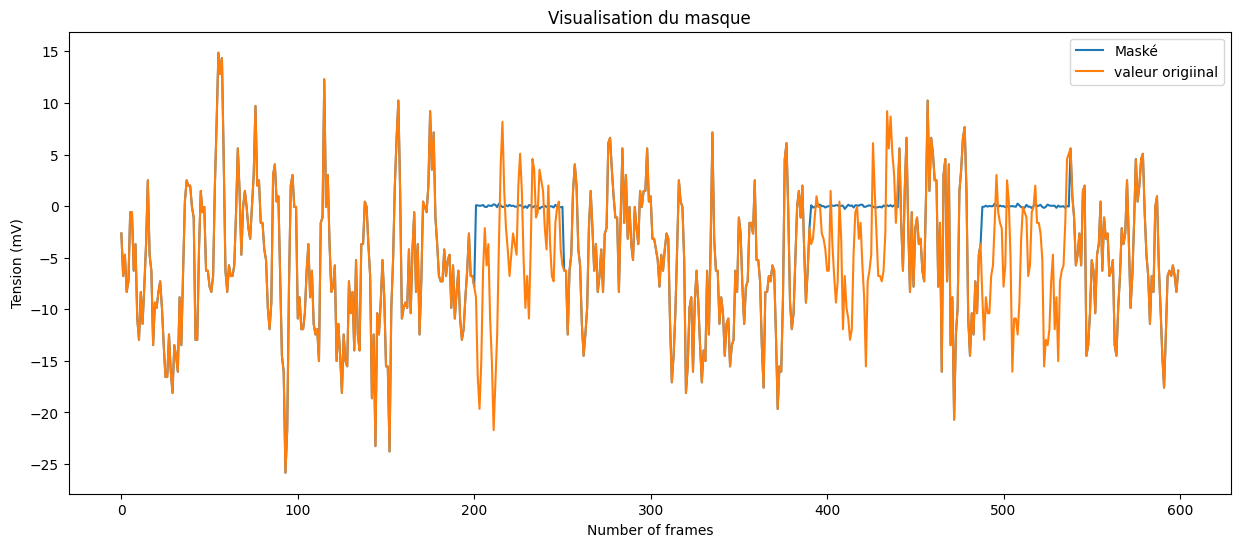

In [114]:
#Viz of the mask

model = BestRqFramework(encoder= ExampleEncoder(),
                        num_temporal_dimension_reduction_steps=100,
                        input_feature_size=600,
                        encoder_hidden_size=20,
                        num_code_books=10,
                        mask_time= 50,
                        stride_time=1,
                        random_state=42,
                        mask_prob=1,
                        batch_size=200)

masked_values,_ = model.masking(inputs)



plt.figure(figsize=(15,6))
for i in range(1):
    plt.plot(masked_values[0,i,:].detach().numpy(), label = 'Maské')
    plt.plot(inputs[0, i ,:].detach().numpy(), label ='valeur origiinal')
plt.legend()
plt.xlabel('Number of frames')
plt.ylabel('Tension (mV)')
plt.title('Visualisation du masque')


In [132]:
dataset_t = TensorDataset(xtrain, ytrain)
train_loader = DataLoader(dataset_t, batch_size= 200, shuffle=True)
dataset_v = TensorDataset(xvalid, yvalid)
valid_loader = DataLoader(dataset_v, batch_size= 200, shuffle=True)
train_losses, valid_losses, accuracies = pretrain(trainloader= train_loader, validloader= valid_loader, model = model, epochs= 40)

  2%|▎         | 1/40 [00:06<04:00,  6.16s/it]

Epoch 1/40, Train Loss: 6.152579127116637, Validation Loss: 5.514558154709485, Accuracy: 0.13529049476493532


  5%|▌         | 2/40 [00:11<03:40,  5.80s/it]

Epoch 2/40, Train Loss: 5.320682416991754, Validation Loss: 5.4105663859114355, Accuracy: 0.15889960993635804


  8%|▊         | 3/40 [00:17<03:40,  5.96s/it]

Epoch 3/40, Train Loss: 5.125781837105751, Validation Loss: 5.1556781214110705, Accuracy: 0.14073085608704577


 10%|█         | 4/40 [00:24<03:39,  6.09s/it]

Epoch 4/40, Train Loss: 5.06518437564373, Validation Loss: 5.096030658605147, Accuracy: 0.16936973927324986


 12%|█▎        | 5/40 [00:30<03:33,  6.09s/it]

Epoch 5/40, Train Loss: 5.022899908911098, Validation Loss: 5.085734060832432, Accuracy: 0.1844590433175939


 15%|█▌        | 6/40 [00:37<03:35,  6.33s/it]

Epoch 6/40, Train Loss: 4.926727281917225, Validation Loss: 5.054096436013981, Accuracy: 0.20498870868404845


 18%|█▊        | 7/40 [00:43<03:29,  6.36s/it]

Epoch 7/40, Train Loss: 4.89854028035294, Validation Loss: 5.139839629737699, Accuracy: 0.20622048860603573


 20%|██        | 8/40 [00:50<03:28,  6.51s/it]

Epoch 8/40, Train Loss: 4.86114589897069, Validation Loss: 5.059182018649821, Accuracy: 0.17624717717101213


 22%|██▎       | 9/40 [00:56<03:17,  6.39s/it]

Epoch 9/40, Train Loss: 4.853984192826531, Validation Loss: 4.87226247300907, Accuracy: 0.16372408129747484


 25%|██▌       | 10/40 [01:02<03:10,  6.35s/it]

Epoch 10/40, Train Loss: 4.85322384075685, Validation Loss: 4.9533703765090635, Accuracy: 0.1987271607472798


 28%|██▊       | 11/40 [01:08<02:57,  6.13s/it]

Epoch 11/40, Train Loss: 4.732281192053448, Validation Loss: 4.917579877133272, Accuracy: 0.22592896735783208


 30%|███       | 12/40 [01:14<02:49,  6.07s/it]

Epoch 12/40, Train Loss: 4.7704559892416, Validation Loss: 4.9825518715138335, Accuracy: 0.2010880722644221


 32%|███▎      | 13/40 [01:20<02:43,  6.06s/it]

Epoch 13/40, Train Loss: 4.7784460986202415, Validation Loss: 4.935434976402594, Accuracy: 0.20683637856702936


 35%|███▌      | 14/40 [01:25<02:34,  5.93s/it]

Epoch 14/40, Train Loss: 4.773300244862383, Validation Loss: 4.862037522452218, Accuracy: 0.21166084992814618


 38%|███▊      | 15/40 [01:31<02:27,  5.92s/it]

Epoch 15/40, Train Loss: 4.759810721874237, Validation Loss: 5.0601548248407795, Accuracy: 0.20396222541572573


 40%|████      | 16/40 [01:37<02:23,  6.00s/it]

Epoch 16/40, Train Loss: 4.7110329329967495, Validation Loss: 4.851417704504364, Accuracy: 0.23260110860192978


 42%|████▎     | 17/40 [01:43<02:15,  5.91s/it]

Epoch 17/40, Train Loss: 4.690964113040404, Validation Loss: 4.874608397483826, Accuracy: 0.21894888113323752


 45%|████▌     | 18/40 [01:49<02:09,  5.89s/it]

Epoch 18/40, Train Loss: 4.719893392920494, Validation Loss: 4.936640089871932, Accuracy: 0.1946212276739889


 48%|████▊     | 19/40 [01:55<02:04,  5.95s/it]

Epoch 19/40, Train Loss: 4.693359942327846, Validation Loss: 4.9253984835683084, Accuracy: 0.21638267296243072


 50%|█████     | 20/40 [02:01<01:58,  5.94s/it]

Epoch 20/40, Train Loss: 4.7118022967468605, Validation Loss: 4.892053263528006, Accuracy: 0.23075343871894888


 52%|█████▎    | 21/40 [02:08<01:57,  6.18s/it]

Epoch 21/40, Train Loss: 4.689946392991326, Validation Loss: 4.875127770462814, Accuracy: 0.22633956066516117


 55%|█████▌    | 22/40 [02:14<01:52,  6.23s/it]

Epoch 22/40, Train Loss: 4.689748500422998, Validation Loss: 4.960634316716876, Accuracy: 0.1818928351467871


 57%|█████▊    | 23/40 [02:21<01:47,  6.31s/it]

Epoch 23/40, Train Loss: 4.707104789939794, Validation Loss: 4.918966008692371, Accuracy: 0.196160952576473


 60%|██████    | 24/40 [02:27<01:42,  6.40s/it]

Epoch 24/40, Train Loss: 4.718998475508257, Validation Loss: 4.88134185878598, Accuracy: 0.17337302401970847


 62%|██████▎   | 25/40 [02:34<01:36,  6.46s/it]

Epoch 25/40, Train Loss: 4.688360782915896, Validation Loss: 4.6677552096697745, Accuracy: 0.24050502976801477


 65%|██████▌   | 26/40 [02:40<01:29,  6.40s/it]

Epoch 26/40, Train Loss: 4.653637382388115, Validation Loss: 4.882018140384129, Accuracy: 0.21063436665982344


 68%|██████▊   | 27/40 [02:46<01:22,  6.34s/it]

Epoch 27/40, Train Loss: 4.629548326405612, Validation Loss: 4.90134490022854, Accuracy: 0.20991582837199754


 70%|███████   | 28/40 [02:53<01:17,  6.45s/it]

Epoch 28/40, Train Loss: 4.624997231906111, Validation Loss: 4.781412676889069, Accuracy: 0.23455142681174296


 72%|███████▎  | 29/40 [02:59<01:10,  6.45s/it]

Epoch 29/40, Train Loss: 4.632543499361385, Validation Loss: 4.725926321379992, Accuracy: 0.22705809895298706


 75%|███████▌  | 30/40 [03:05<01:02,  6.27s/it]

Epoch 30/40, Train Loss: 4.63604105358774, Validation Loss: 4.763462061784705, Accuracy: 0.25477314719770067


 78%|███████▊  | 31/40 [03:11<00:54,  6.08s/it]

Epoch 31/40, Train Loss: 4.652329657294533, Validation Loss: 4.884639472377543, Accuracy: 0.20006158899609935


 80%|████████  | 32/40 [03:17<00:49,  6.18s/it]

Epoch 32/40, Train Loss: 4.6322881655259565, Validation Loss: 4.656391501426697, Accuracy: 0.22110449599671525


 82%|████████▎ | 33/40 [03:25<00:46,  6.58s/it]

Epoch 33/40, Train Loss: 4.606704044883902, Validation Loss: 4.804365630052527, Accuracy: 0.19595565592280845


 85%|████████▌ | 34/40 [03:33<00:42,  7.03s/it]

Epoch 34/40, Train Loss: 4.590744879029014, Validation Loss: 4.815416907777592, Accuracy: 0.23578320673373024


 88%|████████▊ | 35/40 [03:40<00:35,  7.06s/it]

Epoch 35/40, Train Loss: 4.650732922283086, Validation Loss: 4.802167211260114, Accuracy: 0.1773763087661671


 90%|█████████ | 36/40 [03:48<00:29,  7.38s/it]

Epoch 36/40, Train Loss: 4.6117237017913295, Validation Loss: 4.785904173948327, Accuracy: 0.21802504619174706


 92%|█████████▎| 37/40 [03:55<00:21,  7.16s/it]

Epoch 37/40, Train Loss: 4.638877256350084, Validation Loss: 4.770276147492078, Accuracy: 0.21730650790392117


 95%|█████████▌| 38/40 [04:01<00:13,  6.88s/it]

Epoch 38/40, Train Loss: 4.638281247561628, Validation Loss: 4.761894899971631, Accuracy: 0.24399507288031205


 98%|█████████▊| 39/40 [04:08<00:06,  6.80s/it]

Epoch 39/40, Train Loss: 4.6130583922971375, Validation Loss: 4.80798259803227, Accuracy: 0.2591870252514884


100%|██████████| 40/40 [04:14<00:00,  6.36s/it]

Epoch 40/40, Train Loss: 4.597533937475898, Validation Loss: 4.949590201280555, Accuracy: 0.20344898378156437


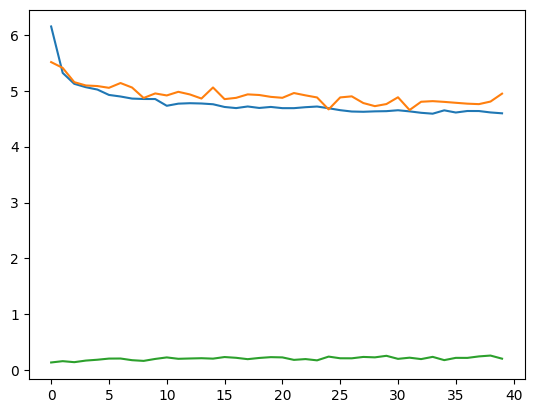

In [133]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(valid_losses, label = 'Validation loss')
plt.plot(accuracies, label ='Validation Accuracy')

In [1]:
import torchaudio

ModuleNotFoundError: No module named 'torchaudio'